# Dungeons and Dragons Combat Simulator

In [1]:
from typing import *
import numpy as np
from abc import ABC, abstractmethod
import random
import main

## Introduction

Our project objective was first to simulate combat using the rules and frameworks of the popular tabletop role-playing game (TTRPG), Dungeons and Dragons (D&D), and then to use those simulated combat scenarios to determine the effectiveness over time of being able to guess an opponent's relavant combat statistics.

In a TTRPG combat scenario, one character or set of characters (called an adventuring party, or simply "party," for short) engages another character or party in battle. In D&D, the players know the relevant statistics for their own characters, and sometimes for their entire party, while the Dungeon Master, or DM, (the chief storyteller of the game, who provides the scenarios and context for the player characters to engage with) often obscures the relevant statistics of the opposing character(s). Usually, the players are entirely unaware of what statistics, skills, and special abilities an enemy combatant posesses until they are exposed to its moveset, attack, and defense abilities in real-time during a battle. Knowing this, we wondered: with a basic understanding of Bayesian probability, how easy or quick would it be for a player party to be able to correctly guess an enemy combatant's relevant statistics in battle?

In order to understand what goes into that process, let's first talk a bit more about the way combat in a TTRPG, namely D&D, is run.

## Dungeons and Dragons Combat Mechanics

Combat, in the world of Dungeons and Dragons, is a surprisingly civilized affair: opposing parties operate on a turn-based system, determined initially by which character is quickest to act (through an "Initiative Roll"), followed by the next, down the line and looping back around to the same order in the next round of combat. During one's turn, a character can act in a few different ways. They can make an Attack, which may be either Melee, Ranged, Magical, or in some cases, using a Special Ability. They can Move, a number of feet based on their Speed statistic. They can also perform Bonus Actions or act upon any other Special Abilities they have.

An Attack hits an opponent if the Attack Roll (1 roll of a 20-sided die, known as a d20, plus the attacker's relevant weapon modifier and Proficiency Bonus, if applicable) is greater than or equal to the defender's Armor Class, or AC (the character's Dexterity modifier, plus 10, plus any bonus from worn armor). Damage is determined by a roll of a die, often either a d4, a d6, or a d8, depending on the weapon used, and the damge is subtracted by the character's total amount of Hit Points, or HP. When a character's HP is 0 or less, the character is unconscious and cannot take further action in battle. Combat ends when one full party is decommissioned from battle, meaning all characters are unconscious or dead, or if one party flees or surrenders in some other manner.

In our model, we have made several simplifications and allowances for ease of following combat proceedings. Since a character's special abilities can become hyper-specialized, further abilities are gained by increasing character level, and the amount of magical combat spells in D&D is exorbitant, we decided to stick to Melee weapons combat, giving each character a weapon that utilizes either their Strength statistic or their Dexterity statistic. Additionally, we decided to ignore speed in an effort for this to not evolve into a project involving game theory, strategy interviews, or any models for random motion. This is D&D combat in its purest, simplest form: a bunch of characters standing around and hitting each other. What could be better?

In [2]:
import random
from typing import *


class Character:
    def __init__(self, name: str, hp: int, dex: int, stren: int, prof: int, weapon_die: int, finesse: bool):
        """
        Creates a new character with the given stats
        :param name: a string, this character's name (and UID)
        :param hp: an int, the maximum HP
        :param dex: an int, the Dexterity score
        :param stren: an int, the Strength score
        :param prof: an int, the character's proficiency bonus
        :param weapon_die: an int, the size of the die that is rolled to determine a weapon's damage
        :param finesse: a boolean, True if the weapon is finesse
        """
        self.name = name
        self.max_hp = hp
        self.hp = hp
        self.dex = dex
        self.stren = stren
        self.prof = prof
        self.weapon_die = weapon_die
        self.finesse = finesse

    @property
    def dex_mod(self) -> int:
        """
        :return: an int, this character's dexterity modifier
        """
        return (self.dex - 10) // 2

    @property
    def str_mod(self) -> int:
        """
        :return: an int, this character's strength modifier
        """
        return (self.stren - 10) // 2

    @property
    def weapon_bonus(self) -> int:
        """
        :return: an int, the character's best bonus
        """
        return max(self.dex_mod, self.str_mod) if self.finesse else self.str_mod

    @property
    def ac(self) -> int:
        """
        :return: an int, this character's armor class
        """
        return 10 + self.dex_mod

    def roll_initiative(self) -> Tuple[int, int]:
        """
        :return: a tuple of ints, this character's initiative followed by their dex score (for tiebreaks)
        """
        return random.randint(1, 20) + self.dex_mod, self.dex

    def roll_to_hit(self) -> int:
        """
        :return: an int, the value this character has rolled to hit
        """
        return random.randint(1, 20) + self.weapon_bonus + self.prof

    def roll_damage(self) -> int:
        """
        :return: an int, the amount of damage this character does
        """
        return random.randint(1, self.weapon_die) + self.weapon_bonus

    def __hash__(self):
        return hash(self.name)

After defining the Character class with relevant statistics, we moved on to simulating the battle. We defined 3 characters, 2 in the player party and 1 in the DM party, using our Character class, then wrote a function that would make them roll Initiative, and in turn order, beat each other up until both members of one party hit 0 HP. Then, we printed messages letting us know which damage was dealt in each turn and a message letting us know which party had won.

In [3]:
def simulate_battle(verbose: bool = False):
    party1 = [Character('Manster Wipower', 90, 10, 10, 0, 8, False),
              Character('Abayes Satano\'brien', 150, 14, 10, 0, 10, False)]
    party2 = [Character('Blelduth Chestsplitter', 240, 14, 10, 0, 8, False)]
    all_characters = {c.name: c for c in party1 + party2}
    initiative = {n: c.roll_initiative() for n, c in all_characters.items()}
    initiative_order = sorted(all_characters.keys(), key=lambda i: initiative[i], reverse=True)

    if verbose:
        print(f'Initiative order is {initiative_order} (scores are {initiative})')
    while True:
        for name in initiative_order:
            character = all_characters[name]
            is_party1 = any(c.name == name for c in party1)
            if character.hp <= 0:
                continue
            other_party = party2 if is_party1 else party1
            if all(c.hp <= 0 for c in other_party):
                break
            opponent = random.choice(other_party)
            while opponent.hp <= 0:
                opponent = random.choice(other_party)

            to_hit = character.roll_to_hit()
            hit = to_hit >= opponent.ac
            if hit:
                damage = character.roll_damage()
                opponent.hp -= damage
                if verbose:
                    print(f'{name} hit {opponent.name} for {damage} damage (they have {opponent.hp} HP left)')
                    if opponent.hp <= 0:
                        print(f'{opponent.name} is DEAD')
        if all(c.hp <= 0 for c in party1):
            if verbose:
                print('Freak the Mighty wins!')
            break
        if all(c.hp <= 0 for c in party2):
            if verbose:
                print('Hell Raisers win!')
            break

After we had created a working simulation of a simplified combat scenario, it was time to introduce our means of estimation.

## Estimators

After we had a rough simulation of how combat worked in D&D, we wrote estimator classes to estimate important values for us over the course of the battle. `Estimator` is a base class which implements Bayes' rule on discrete inputs - this works well enough for us as nothing in D&D is continuous. Given a number of options as input, it sets the prior to a uniform distribution across them, and defines functions for updating this prior given a measurement, along with functions to calculate the Maximum A Posteriori and the mean of the distribution. Each subclass of `Estimator` must define `model` - a function that takes in a measurement and returns the likelihood of the measurement happening given each value of the variable we are trying to estimate.

In [4]:
class Estimator(ABC):
    """
    Class to estimate a certain statistic

    Attributes:
        current_estimate: a numpy vector giving the probability of each option
        noptions: int, the number of options
        xvals: the range of possible values of the statistic to estimate
    """
    def __init__(self, noptions: int):
        self.current_estimate = np.ones((noptions,)) / noptions

    @property
    def noptions(self) -> int:
        return self.current_estimate.shape[0]

    @property
    def xvals(self) -> np.ndarray:
        return np.arange(self.noptions)

    def set_prior(self, prior: np.ndarray):
        """
        Sets the prior distribution

        :param prior: an ndarray, the prior distribution
        """
        assert sum(prior) == 1
        self.current_estimate = prior

    @abstractmethod
    def model(self, measurement) -> np.ndarray:
        """
        Calculates the probability of the measurement for each option

        :param measurement: the most recent measurement
        :return: a numpy vector with (noptions) elements, giving the probability of this measurement
          given the estimated value
        """
        pass

    def update(self, measurement):
        """
        Update the current belief given a measurement, as per Bayes' Rule

        :param measurement: the measured value
        """
        self.current_estimate *= self.model(measurement)
        self.current_estimate /= np.sum(self.current_estimate)

    def map(self) -> float:
        """
        :return: a float, the Maximum A Posteriori (or the average of them in the case of multiple) of the current estimate
        """
        highest = np.max(self.current_estimate)
        modes = self.current_estimate == highest
        return np.sum(self.current_estimate[modes]) / len(modes)

    def mean(self) -> float:
        """
        :return: a float, the weighted mean of the current estimate
        """
        return sum(self.current_estimate * np.arange(self.current_estimate.shape[0]))

We then made two subclasses of `Estimator` - `ModifierEstimator` and `ACEstimator`. These each define their own models given a certain measurement. Here is `ACEstimator`:

In [5]:
class ACEstimator(Estimator):
    def __init__(self):
        super().__init__(31)  # 0 to 30

    def model(self, measurement: Tuple[int, bool]):
        """
        Calculates the probability of the measurement for each option

        :param measurement: a tuple - the most recent roll followed by whether it hit
        :return: a numpy vector with (noptions) elements, giving the probability of this measurement given the
            estimated value
        """
        roll, hit = measurement
        if hit:
            return self.xvals <= roll
        return self.xvals > roll

The input to this function is two values: first, the roll to hit, and second, whether or not that roll hit (whether it passed the AC). This function is very basic, as the AC determines whether or not the attack hits - i.e. for each AC, the given measurement is either completely possible (probability 1) or completely impossible (probability 0).

`ModifierEstimator` has a different `model` function. Note that the `xvals` property is overriden as modifiers can be negative

In [6]:
class ModifierEstimator(Estimator):
    def __init__(self):
        super().__init__(21)  # -5 to 15

    @property
    def xvals(self) -> np.ndarray:
        return np.arange(self.noptions) - 5

    def model(self, measurement: int) -> np.ndarray:
        """
        Calculates the probability of the measurement for each option

        :param measurement: an int, the most recent roll
        :return: a numpy vector with (noptions) elements, giving the probability of this measurement given the
            estimated value
        """
        poss_rolls = measurement - self.xvals
        in_range = (1 <= poss_rolls) & (poss_rolls <= 20)
        return in_range / 20

The measurement for this model is the roll that the opponent made. Given each possible modifier from -5 to 15, there is either a 5% chance of seeing that roll, or a 0% chance of seeing that roll. This function sets those probabilities accordingly.

## Results

Since both the prior we used and the model for each statistic are uniform distributions, the estimator only gives uniform distributions back. However, the range of that distribution shrinks over time. We can plot this shrinking:

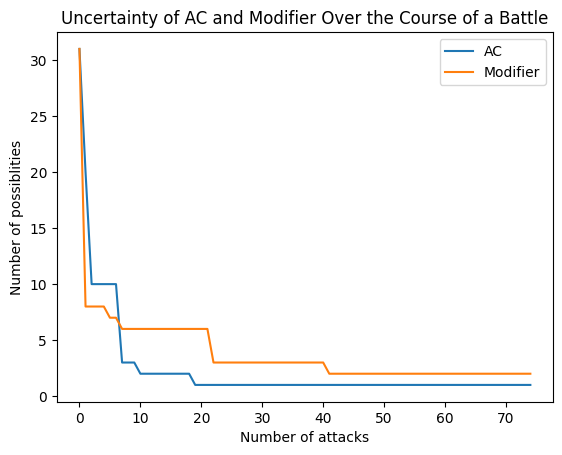

In [7]:
acrange, modrange = main.simulate_battle()  # Same as above, but estimates statistics
main.display_range_plots(acrange, modrange)

This graph is roughly exponential decay. However, the exact speed of the decay varies a lot, as can be seen if many graphs are generated. The question became, how many data points are needed until each statistic is known? To calculate this, we ran 10,000 battle simulations and saved how long it took until each statistic was known, and plotted a histogram of these values.

Mean is 30.138, stdev is 22.066
Median is 24
Skew is 1.63, kurtosis is 4.01


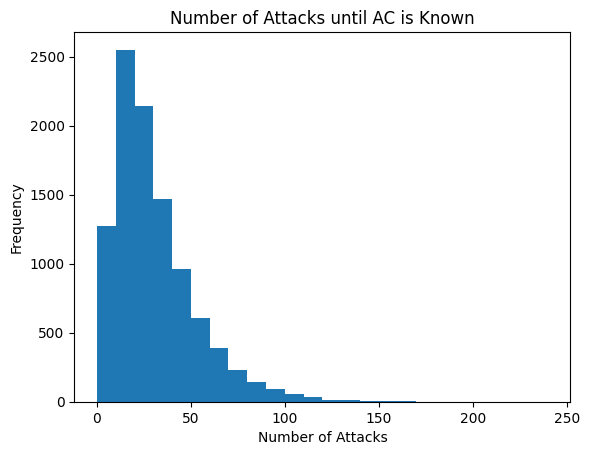

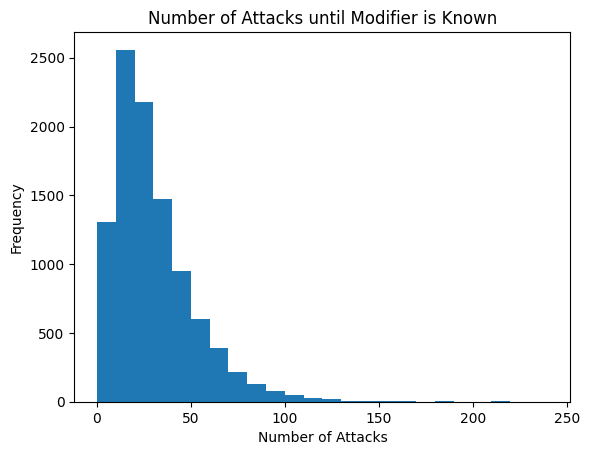

In [8]:
main.main()

These two distributions are pretty much exactly identical. This makes sense - the problem is merely two sides of the same coin. Either way, each roll rules out any choices above or below it (depending on the roll) until only one option is left.

## Conclusion

Estimating both AC and Modifier have a very similar method - keep track of highest and lowest possible values. However, with Bayes' rule, we can formulate this in a different way using statistics, which lets us run easy simulations and also allows for flexibility in the sense of a prior belief. This method also proves the similarity between AC and Modifier estimation. After running many simulations, we have shown that the two distributions are the same, and that it will take somewhere around 24 attacks to know one of an enemy's stats.